In [31]:
import duckdb
import pandas as pd
import numpy as np

In [17]:
# Path to your Parquet file
parquet_path = "../../sampling/data/combined_dataset.parquet"

# Connect to DuckDB (in-memory)
con = duckdb.connect()

# Read Parquet file and cast to Pandas DataFrame
messages_df = con.execute(f"SELECT * FROM read_parquet('{parquet_path}')").df()

In [18]:
messages_df

,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date
0,689791327,1515915625489087633-11387-64244e6bd4d4e,11387,bulk,1515915625489087633,mobile_push,<NA>,None,None,desktop,...,30.0,False,False,True,False,False,False,<NA>,NaN,None
1,689792401,1515915625489107288-11387-64244e6bd72d3,11387,bulk,1515915625489107288,mobile_push,<NA>,None,None,desktop,...,30.0,False,False,True,False,False,False,<NA>,NaN,None
2,689792664,1515915625489112445-11387-64244e6bd81d6,11387,bulk,1515915625489112445,mobile_push,<NA>,None,None,desktop,...,30.0,False,False,True,False,False,False,<NA>,NaN,None
3,689793297,1515915625489122538-11387-64244e6bd98c2,11387,bulk,1515915625489122538,mobile_push,<NA>,None,None,desktop,...,30.0,False,False,True,False,False,False,<NA>,NaN,None
4,689793902,1515915625489133634-11387-64244e6bdb2a6,11387,bulk,1515915625489133634,mobile_push,<NA>,None,None,desktop,...,30.0,False,False,True,False,False,False,<NA>,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686879,689491011,1515915625491065738-11208-6423f06fdbc9a,11208,bulk,1515915625491065738,email,<NA>,None,mail.ru,desktop,...,119.0,False,False,True,False,False,False,<NA>,NaN,None
1686880,689491372,1515915625491066422-11208-6423f04f5dd4e,11208,bulk,1515915625491066422,email,<NA>,None,mail.ru,desktop,...,119.0,False,False,True,False,False,False,<NA>,NaN,None
1686881,689491993,1515915625491067653-11208-6423f0c79baa8,11208,bulk,1515915625491067653,email,<NA>,None,rambler.ru,desktop,...,119.0,False,False,True,False,False,False,<NA>,NaN,None
1686882,689492186,1515915625491068074-11208-6423f0ce29065,11208,bulk,1515915625491068074,email,<NA>,None,gmail.com,desktop,...,119.0,False,False,True,False,False,False,<NA>,NaN,None


In [24]:
# Proportion analysis for requested fields (robust resolution + derived flags)
import numpy as np
import pandas as pd
import difflib

# Helper: normalize a column name for matching
normalize = lambda s: ''.join(ch if ch.isalnum() or ch=='_' else '_' for ch in s.lower()).replace('__','_')

# Typical timestamp columns that imply boolean flags
derived_ts_map = {
    'is_opened': 'opened_first_time_at',
    'is_clicked': 'clicked_first_time_at',
    'is_purchased': 'first_purchase_date',
    'is_blocked': 'blocked_at',
    'is_unsubscribed': 'unsubscribed_at',
    'is_soft_bounced': 'soft_bounced_at',
    'is_complained': 'complained_at',
}

# Aliases and typo fixes
alias_map = {
    'is unsubscribed': 'is_unsubscribed',
    'subject_with_salueout': 'subject_with_saleout',  # typo tolerance
}

# Resolve a requested column name to an existing or derived column in messages_df
def resolve_or_derive(df: pd.DataFrame, requested: str):
    req_norm = normalize(alias_map.get(requested, requested))

    # 1) Exact match (case/format-insensitive)
    by_norm = {normalize(c): c for c in df.columns}
    if req_norm in by_norm:
        return by_norm[req_norm]

    # 2) Derive from timestamp column if applicable
    if req_norm in derived_ts_map:
        ts_col_norm = normalize(derived_ts_map[req_norm])
        if ts_col_norm in by_norm:
            ts_col = by_norm[ts_col_norm]
            out_col = req_norm  # e.g., 'is_opened'
            if out_col not in df.columns:
                df[out_col] = pd.to_datetime(df[ts_col], errors='coerce').notna()
            return out_col

    # 3) Try fuzzy match to existing columns
    candidates = difflib.get_close_matches(req_norm, list(by_norm.keys()), n=1, cutoff=0.8)
    if candidates:
        return by_norm[candidates[0]]

    # 4) Try partial contains match
    parts = [p for p in req_norm.split('_') if p]
    matches = [c for c in df.columns if all(p in normalize(c) for p in parts)]
    if matches:
        return matches[0]

    return None

# Compute proportions for a list of requested columns
requested_columns = [
    'message_type','channel_x','channel_y','stream',
    'is_opened','is_clicked','is unsubscribed','is_soft_bounced','is_complained','is_blocked','is_purchased',
    'campaign_type','topic','ab_test','warmup_mode',
    'subject_with_personalization','subject_with_deadline','subject_with_emoji','subject_with_bonuses','subject_with_discount','subject_with_salueout'
]

resolved = []
missing = []
for r in requested_columns:
    col = resolve_or_derive(messages_df, r)
    if col is None:
        missing.append(r)
    else:
        resolved.append((r, col))

# Build a tidy summary table: column, value, count, proportion
records = []
N = len(messages_df)
for req, col in resolved:
    vc = messages_df[col].value_counts(dropna=False, normalize=False)
    prop = messages_df[col].value_counts(dropna=False, normalize=True)
    for val, cnt in vc.items():
        records.append({
            'requested': req,
            'column_used': col,
            'value': val,
            'count': int(cnt),
            'proportion': float(prop.loc[val])*100
        })

prop_df = pd.DataFrame(records)
if not prop_df.empty:
    # Order for readability
    prop_df = prop_df.sort_values(['requested','proportion'], ascending=[True, False])
    display(prop_df)
else:
    print('No proportions to display — none of the requested columns were found.')

if missing:
    print('\nColumns not found (after aliasing/derivation attempts):')
    for m in missing:
        print('-', m)

,requested,column_used,value,count,proportion
56,ab_test,ab_test,<NA>,1677944,99.470029
57,ab_test,ab_test,True,8940,0.529971
28,campaign_type,campaign_type,bulk,1563273,92.672229
29,campaign_type,campaign_type,trigger,85264,5.054527
30,campaign_type,campaign_type,transactional,38347,2.273245
...,...,...,...,...,...
54,topic,topic,price drop,79,0.004683
55,topic,topic,back in stock,4,0.000237
58,warmup_mode,warmup_mode,False,1537137,91.122863
59,warmup_mode,warmup_mode,<NA>,123611,7.327771


# Opened

In [ ]:
# Subdataframes: opened and reopened (robust with datetime coercion)
required_cols = ['opened_first_time_at', 'opened_last_time_at']
missing_cols = [c for c in required_cols if c not in messages_df.columns]
if missing_cols:
    raise KeyError(f"Missing required columns: {missing_cols}")

# Coerce to datetime (does not modify original columns)
ofirst = pd.to_datetime(messages_df['opened_first_time_at'], errors='coerce')
olast = pd.to_datetime(messages_df['opened_last_time_at'], errors='coerce')

# 1) Rows with non-missing opened_first_time_at
opened_df = messages_df[ofirst.notna()].copy()

# 2) Rows where last open exists and differs from first open (i.e., reopened)
reopened_mask = ofirst.notna() & olast.notna() & (olast != ofirst)
reopened_df = messages_df[reopened_mask].copy()

print('opened_df shape:', opened_df.shape)
print('reopened_df shape:', reopened_df.shape)
print('\nopened_df')
display(opened_df)
print('\nreopened_df')
display(reopened_df)

opened_df shape: (315943, 54)
reopened_df shape: (14212, 54)

opened_df


,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date,opened_first_time_at_flag,clicked_first_time_at_flag,first_purchase_date_flag
9,689795298,1515915625489159941-11387-64244e6bde7ad,11387,bulk,1515915625489159941,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,2022-05-27,True,False,True
13,689795685,1515915625489166981-11387-64244e6bdfa12,11387,bulk,1515915625489166981,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,None,True,False,False
16,689796369,1515915625489180362-11387-64244e6be15c9,11387,bulk,1515915625489180362,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,2022-10-22,True,False,True
23,689798559,1515915625491095481-11208-6423f0ce2a7e7,11208,bulk,1515915625491095481,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False
32,689802992,1515915625491105636-11208-6423f0ae023c7,11208,bulk,1515915625491105636,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686861,689485745,1515915625488886798-11387-64244e6bc0a10,11387,bulk,1515915625488886798,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,None,True,False,False
1686863,689486613,1515915625488924413-11387-64244e6bc2bc4,11387,bulk,1515915625488924413,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,None,True,False,False
1686865,689487324,1515915625488952118-11387-64244e6bc4797,11387,bulk,1515915625488952118,mobile_push,<NA>,android,None,android,...,True,False,False,False,<NA>,NaN,2023-03-25,True,False,True
1686871,689490038,1515915625491063676-11208-6423f134233e6,11208,bulk,1515915625491063676,email,<NA>,None,bk.ru,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False



reopened_df


,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date,opened_first_time_at_flag,clicked_first_time_at_flag,first_purchase_date_flag
579,692001511,1515915625488006208-11491-642bd74476ef3,11491,bulk,1515915625488006208,email,<NA>,None,yandex.ru,desktop,...,True,False,False,False,<NA>,NaN,2022-08-22,True,False,True
609,649971617,1515915625764178163-10507-63ff04ff12568,10507,bulk,1515915625764178163,email,<NA>,None,mail.ru,desktop,...,True,False,False,False,<NA>,NaN,2023-02-17,True,False,True
1346,695554049,1515915625487589960-11760-643674a256199,11760,bulk,1515915625487589960,email,<NA>,None,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,None,True,False,False
1451,695927143,1515915625501454160-11760-6436748e507d3,11760,bulk,1515915625501454160,email,<NA>,None,gmail.com,desktop,...,True,False,True,False,<NA>,NaN,None,True,False,False
2033,698360830,1515915625490946762-11806-6437ee830b981,11806,bulk,1515915625490946762,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686269,675122376,1515915625490952774-10988-6414101aada61,10988,bulk,1515915625490952774,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False
1686274,665472515,1515915625501990030-10792-640ad934c23bd,10792,bulk,1515915625501990030,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False
1686275,666363315,1515915625559856100-10792-640ad982f21ac,10792,bulk,1515915625559856100,email,<NA>,None,yandex.ru,desktop,...,True,False,False,False,<NA>,NaN,2023-11-26,True,False,True
1686276,666091129,1515915625559756122-10792-640ad987dab04,10792,bulk,1515915625559756122,email,<NA>,None,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,False,False


In [ ]:
# Ensure reopened_df exists; if not, derive it quickly
if 'reopened_df' not in globals():
    if 'opened_first_time_at' not in messages_df.columns or 'opened_last_time_at' not in messages_df.columns:
        raise KeyError('opened_first_time_at and opened_last_time_at are required to compute reopened_df')
    _ofirst = pd.to_datetime(messages_df['opened_first_time_at'], errors='coerce')
    _olast = pd.to_datetime(messages_df['opened_last_time_at'], errors='coerce')
    _reopened_mask = _ofirst.notna() & _olast.notna() & (_olast != _ofirst)
    reopened_df = messages_df[_reopened_mask].copy()

print('reopened_df shape:', reopened_df.shape)

summary_records = []
for col in ['topic', 'campaign_type']:
    if col not in reopened_df.columns:
        print(f"Column not found in reopened_df: {col}")
        continue
    vc = reopened_df[col].value_counts(dropna=False)
    prop = reopened_df[col].value_counts(dropna=False, normalize=True) * 100
    for val, cnt in vc.items():
        summary_records.append({
            'column': col,
            'value': val,
            'count': int(cnt),
            'proportion_pct': float(prop.loc[val])
        })

prop_reopened = pd.DataFrame(summary_records)
if not prop_reopened.empty:
    prop_reopened = prop_reopened.sort_values(['column','proportion_pct'], ascending=[True, False])
    display(prop_reopened)
else:
    print('No proportions to display for reopened_df.')

reopened_df shape: (14212, 54)


,column,value,count,proportion_pct
22,campaign_type,bulk,11909,83.795384
23,campaign_type,trigger,1283,9.027582
24,campaign_type,transactional,1020,7.177033
0,topic,sale out,11695,82.289614
1,topic,abandoned view,425,2.990431
2,topic,order created,309,2.174219
3,topic,order ready for pickup,262,1.843513
4,topic,subscribed,231,1.625387
5,topic,recent purchase,221,1.555024
6,topic,abandoned category,178,1.252463


# Clicked

In [35]:
req_cols = ['clicked_first_time_at', 'clicked_last_time_at']
miss = [c for c in req_cols if c not in messages_df.columns]
if miss:
    raise KeyError(f"Missing required columns: {miss}")

cfirst = pd.to_datetime(messages_df['clicked_first_time_at'], errors='coerce')
clast = pd.to_datetime(messages_df['clicked_last_time_at'], errors='coerce')

# 1) Rows with non-missing first click
clicked_df = messages_df[cfirst.notna()].copy()

# 2) Rows where last click exists and differs from first click (multi-click)
reclicked_mask = cfirst.notna() & clast.notna() & (clast != cfirst)
reclicked_df = messages_df[reclicked_mask].copy()

print('clicked_df shape:', clicked_df.shape)
print('reclicked_df shape:', reclicked_df.shape)
print('\nclicked_df')
display(clicked_df)
print('\nreclicked_df')
display(reclicked_df)

clicked_df shape: (17865, 54)
reclicked_df shape: (4818, 54)

clicked_df


,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date,opened_first_time_at_flag,clicked_first_time_at_flag,first_purchase_date_flag
1007,693818427,1515915625488892480-11608-642fdc5dde3a0,11608,bulk,1515915625488892480,email,<NA>,desktop,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,2023-04-12,True,True,True
1238,695209499,1515915625500813576-11608-642fdd288fb41,11608,bulk,1515915625500813576,email,<NA>,smartphone,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,None,True,True,False
1292,695228053,1515915625536056376-11608-642fdcb6436dd,11608,bulk,1515915625536056376,email,<NA>,smartphone,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,2022-03-13,True,True,True
1329,695547227,1515915625487197291-11760-6436743df0ab6,11760,bulk,1515915625487197291,email,<NA>,phablet,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,None,True,True,False
1343,695552237,1515915625487210389-11760-643673fb0c883,11760,bulk,1515915625487210389,email,<NA>,desktop,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,None,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685133,681454780,1515915625490198024-11144-641ad1fae774d,11144,bulk,1515915625490198024,email,<NA>,smartphone,mail.ru,desktop,...,True,False,False,True,<NA>,NaN,None,True,True,False
1685773,684047416,1515915625489405081-11207-641c57ef0c380,11207,bulk,1515915625489405081,mobile_push,<NA>,None,None,ios,...,True,False,False,False,<NA>,NaN,None,False,True,False
1685787,684392026,1515915625898088252-11207-641c57f6c3be3,11207,bulk,1515915625898088252,mobile_push,<NA>,None,None,ios,...,True,False,False,False,<NA>,NaN,2022-12-16,False,True,True
1685988,685247208,1515915625723354013-11209-641d582a1bdca,11209,bulk,1515915625723354013,email,<NA>,smartphone,mail.ru,desktop,...,True,False,False,False,<NA>,NaN,None,True,True,False



reclicked_df


,id,message_id,campaign_id,message_type,client_id,channel_x,category,platform,email_provider,stream,...,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date,opened_first_time_at_flag,clicked_first_time_at_flag,first_purchase_date_flag
1766,696963154,1515915625566858814-11760-6436743bbffb8,11760,bulk,1515915625566858814,email,<NA>,desktop,inbox.ru,desktop,...,True,False,True,False,<NA>,NaN,2023-04-12,True,True,True
1776,696968801,1515915625484672906-11760-643673f3af9e5,11760,bulk,1515915625484672906,email,<NA>,desktop,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,2023-01-31,True,True,True
1936,697835485,1515915625556308576-11760-643674490067c,11760,bulk,1515915625556308576,email,<NA>,desktop,mail.ru,desktop,...,True,False,True,False,<NA>,NaN,None,True,True,False
2261,699648130,1515915625864632782-11796-643902d4c79e4,11796,bulk,1515915625864632782,mobile_push,<NA>,android,None,android,...,True,False,True,False,<NA>,NaN,2023-02-23,True,True,True
2421,700625792,1515915625893865461-11796-643902d70ade5,11796,bulk,1515915625893865461,mobile_push,<NA>,smartphone,None,desktop,...,True,False,True,False,<NA>,NaN,None,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682096,666529434,1515915625557126770-10852-640b569b28d8a,10852,bulk,1515915625557126770,mobile_push,<NA>,smartphone,None,desktop,...,True,False,False,False,<NA>,NaN,2023-06-11,False,True,True
1682419,667824880,1515915625491274364-10792-640ad97b5c34a,10792,bulk,1515915625491274364,email,<NA>,smartphone,gmail.com,desktop,...,True,False,False,False,<NA>,NaN,None,True,True,False
1684148,675095311,1515915625590175241-10988-6414102d8d258,10988,bulk,1515915625590175241,email,<NA>,desktop,bk.ru,desktop,...,True,False,False,False,<NA>,NaN,None,True,True,False
1684322,675787229,1515915625939905909-10988-64141015364f6,10988,bulk,1515915625939905909,email,<NA>,desktop,yandex.ru,desktop,...,True,False,False,False,<NA>,NaN,2023-03-16,True,True,True


In [ ]:
if 'reclicked_df' not in globals():
    raise NameError('reclicked_df is not defined; run the previous cell first.')

print('reclicked_df shape:', reclicked_df.shape)

summary = []
for col in ['topic', 'campaign_type']:
    if col not in reclicked_df.columns:
        print(f'Missing column in reclicked_df: {col}')
        continue
    vc = reclicked_df[col].value_counts(dropna=False)
    prop = reclicked_df[col].value_counts(dropna=False, normalize=True) * 100
    for v, cnt in vc.items():
        summary.append({
            'column': col,
            'value': v,
            'count': int(cnt),
            'proportion_pct': float(prop.loc[v])
        })

prop_reclicked = pd.DataFrame(summary)
if not prop_reclicked.empty:
    prop_reclicked = prop_reclicked.sort_values(['column','proportion_pct'], ascending=[True, False])
    display(prop_reclicked)
else:
    print('No data to display for reclicked_df proportions.')

reclicked_df shape: (4818, 54)


,column,value,count,proportion_pct
19,campaign_type,bulk,3496,72.561229
20,campaign_type,trigger,960,19.925280
21,campaign_type,transactional,362,7.513491
0,topic,sale out,3471,72.042341
1,topic,abandoned view,431,8.945621
2,topic,recent purchase,159,3.300125
3,topic,welcome letter,141,2.926526
4,topic,abandoned category,129,2.677460
5,topic,abandoned cart,109,2.262350
6,topic,subscribed,92,1.909506


In [45]:
# Per-campaign proportions (wide format with requested columns as columns)
import pandas as pd
import numpy as np

if 'campaign_id' not in messages_df.columns:
    raise KeyError('campaign_id column not found in messages_df')

# Reuse resolved columns from cell 5
if 'resolved' not in globals() or not resolved:
    print('Warning: resolved columns list not found. Re-running cell 5 logic inline...')
    requested_columns = [
        'message_type','channel_x','channel_y','stream',
        'is_opened','is_clicked','is_unsubscribed','is_soft_bounced','is_complained','is_blocked','is_purchased',
        'campaign_type','topic','ab_test','warmup_mode',
        'subject_with_personalization','subject_with_deadline','subject_with_emoji','subject_with_bonuses','subject_with_discount','subject_with_saleout'
    ]
    resolved = []
    for r in requested_columns:
        col = resolve_or_derive(messages_df, r) if 'resolve_or_derive' in globals() else (r if r in messages_df.columns else None)
        if col is not None:
            resolved.append((r, col))

campaign_ids = messages_df['campaign_id'].dropna().unique()
print(f'Analyzing {len(campaign_ids)} unique campaigns...')

# Build one row per campaign with aggregated metrics
campaign_summary = []
for cid in campaign_ids:
    subset = messages_df[messages_df['campaign_id'] == cid]
    N = len(subset)
    if N == 0:
        continue
    
    row = {'campaign_id': cid, 'n_messages': N}
    
    # For each requested column, compute the proportion of the most common value (mode)
    # and store both the mode value and its proportion
    for req, col in resolved:
        if col not in subset.columns:
            row[f'{req}_mode'] = None
            row[f'{req}_mode_pct'] = None
            continue
        
        vc = subset[col].value_counts(dropna=False, normalize=False)
        if len(vc) == 0:
            row[f'{req}_mode'] = None
            row[f'{req}_mode_pct'] = None
        else:
            top_val = vc.index[0]
            top_pct = (vc.iloc[0] / N) * 100
            row[f'{req}_mode'] = top_val
            row[f'{req}_mode_pct'] = round(top_pct, 2)
    
    campaign_summary.append(row)

prop_by_campaign_wide = pd.DataFrame(campaign_summary)
if not prop_by_campaign_wide.empty:
    # Sort by campaign_id
    prop_by_campaign_wide = prop_by_campaign_wide.sort_values('campaign_id')
    print(f'\nGenerated wide-format table with {len(prop_by_campaign_wide)} campaigns.')
    print('Each requested column has two derived columns: <field>_mode (most common value) and <field>_mode_pct (its proportion).')
    prop_by_campaign_wide.drop(columns=["message_type_mode_pct", "channel_x_mode_pct", "channel_y_mode_pct", "stream_mode_pct", "campaign_type_mode_pct", "topic_mode_pct", "ab_test_mode_pct"], axis=1, inplace=True) 
    prop_by_campaign_wide = prop_by_campaign_wide[prop_by_campaign_wide['message_type_mode'] != "transactional"]
    display(prop_by_campaign_wide)
else:
    print('No per-campaign data to display.')

Analyzing 1553 unique campaigns...

Generated wide-format table with 1553 campaigns.
Each requested column has two derived columns: <field>_mode (most common value) and <field>_mode_pct (its proportion).

Generated wide-format table with 1553 campaigns.
Each requested column has two derived columns: <field>_mode (most common value) and <field>_mode_pct (its proportion).


,campaign_id,n_messages,message_type_mode,channel_x_mode,channel_y_mode,stream_mode,is_opened_mode,is_opened_mode_pct,is_clicked_mode,is_clicked_mode_pct,...,subject_with_deadline_mode,subject_with_deadline_mode_pct,subject_with_emoji_mode,subject_with_emoji_mode_pct,subject_with_bonuses_mode,subject_with_bonuses_mode_pct,subject_with_discount_mode,subject_with_discount_mode_pct,subject_with_salueout_mode,subject_with_salueout_mode_pct
692,63,119,bulk,mobile_push,mobile_push,desktop,False,58.82,False,100.00,...,False,100.0,True,100.0,False,100.0,False,100.0,False,100.0
253,64,4834,bulk,mobile_push,mobile_push,desktop,False,87.51,False,100.00,...,False,100.0,True,50.0,False,100.0,False,100.0,False,100.0
255,78,166,bulk,mobile_push,mobile_push,desktop,False,69.88,False,100.00,...,False,100.0,True,100.0,False,100.0,False,100.0,False,100.0
254,79,2164,bulk,mobile_push,mobile_push,desktop,False,80.78,False,100.00,...,False,100.0,True,100.0,False,100.0,False,100.0,False,100.0
256,89,105,bulk,mobile_push,mobile_push,desktop,False,81.90,False,100.00,...,True,100.0,True,100.0,False,100.0,False,100.0,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,18223,2965,trigger,email,multichannel,desktop,False,74.17,False,97.54,...,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0
240,19017,2622,trigger,email,multichannel,desktop,False,80.55,False,98.82,...,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0
818,19867,28,trigger,mobile_push,multichannel,android,True,82.14,False,100.00,...,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0
691,19868,51,trigger,mobile_push,multichannel,desktop,False,62.75,False,100.00,...,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0,<NA>,100.0


Found 16 non-date numeric columns.
Columns: ['campaign_id', 'n_messages', 'is_opened_mode_pct', 'is_clicked_mode_pct', 'is unsubscribed_mode_pct', 'is_soft_bounced_mode_pct', 'is_complained_mode_pct', 'is_blocked_mode_pct', 'is_purchased_mode_pct', 'warmup_mode_mode_pct', 'subject_with_personalization_mode_pct', 'subject_with_deadline_mode_pct', 'subject_with_emoji_mode_pct', 'subject_with_bonuses_mode_pct', 'subject_with_discount_mode_pct', 'subject_with_salueout_mode_pct'] 

Correlation matrix shape: (16, 16)


,campaign_id,n_messages,is_opened_mode_pct,is_clicked_mode_pct,is unsubscribed_mode_pct,is_soft_bounced_mode_pct,is_complained_mode_pct,is_blocked_mode_pct,is_purchased_mode_pct,warmup_mode_mode_pct,subject_with_personalization_mode_pct,subject_with_deadline_mode_pct,subject_with_emoji_mode_pct,subject_with_bonuses_mode_pct,subject_with_discount_mode_pct,subject_with_salueout_mode_pct
campaign_id,1.000000,0.141264,-0.169308,0.073420,0.162125,-0.024058,0.034769,-0.012722,0.042543,0.059972,NaN,NaN,0.059972,NaN,0.041252,NaN
n_messages,0.141264,1.000000,0.096393,0.030337,0.024723,-0.076327,0.013647,-0.010575,0.010301,-0.022593,NaN,NaN,-0.022593,NaN,0.011034,NaN
is_opened_mode_pct,-0.169308,0.096393,1.000000,0.079963,-0.026693,-0.057418,-0.025017,0.006890,0.044263,-0.007862,NaN,NaN,-0.007862,NaN,0.002439,NaN
is_clicked_mode_pct,0.073420,0.030337,0.079963,1.000000,-0.006151,-0.011263,-0.001094,-0.008725,0.276624,-0.003832,NaN,NaN,-0.003832,NaN,0.001476,NaN
is unsubscribed_mode_pct,0.162125,0.024723,-0.026693,-0.006151,1.000000,0.115493,0.306426,0.005564,-0.004966,0.127061,NaN,NaN,0.127061,NaN,0.026928,NaN
is_soft_bounced_mode_pct,-0.024058,-0.076327,-0.057418,-0.011263,0.115493,1.000000,0.247735,0.011325,-0.003876,-0.004907,NaN,NaN,-0.004907,NaN,-0.003468,NaN
is_complained_mode_pct,0.034769,0.013647,-0.025017,-0.001094,0.306426,0.247735,1.000000,0.053108,-0.002276,-0.002668,NaN,NaN,-0.002668,NaN,-0.001886,NaN
is_blocked_mode_pct,-0.012722,-0.010575,0.006890,-0.008725,0.005564,0.011325,0.053108,1.000000,-0.001738,-0.002207,NaN,NaN,-0.002207,NaN,-0.001560,NaN
is_purchased_mode_pct,0.042543,0.010301,0.044263,0.276624,-0.004966,-0.003876,-0.002276,-0.001738,1.000000,-0.001515,NaN,NaN,-0.001515,NaN,-0.001071,NaN
warmup_mode_mode_pct,0.059972,-0.022593,-0.007862,-0.003832,0.127061,-0.004907,-0.002668,-0.002207,-0.001515,1.000000,NaN,NaN,1.000000,NaN,0.706873,NaN


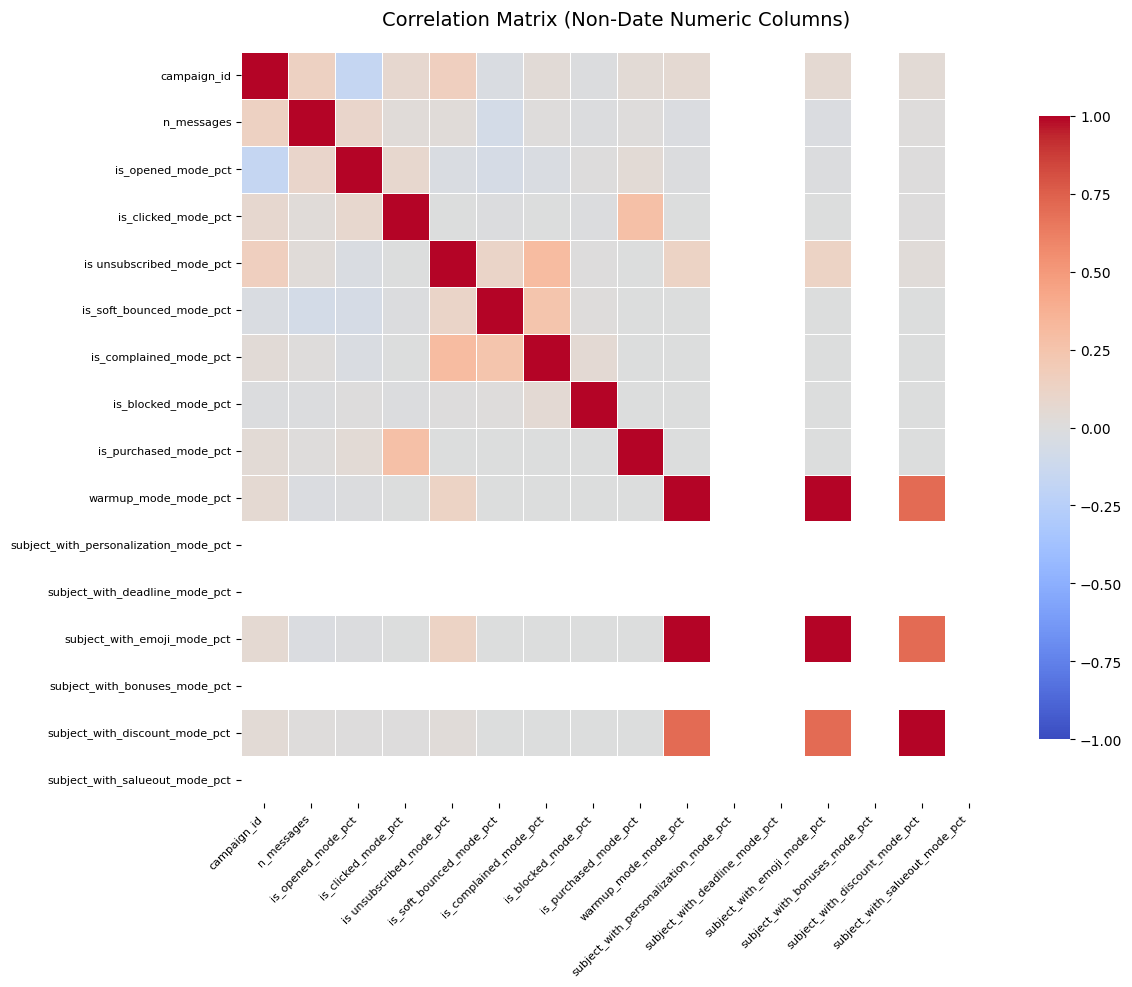


Top 20 strongest correlations (absolute value):


,var1,var2,correlation
101,warmup_mode_mode_pct,subject_with_emoji_mode_pct,1.000000
115,subject_with_emoji_mode_pct,subject_with_discount_mode_pct,0.706873
103,warmup_mode_mode_pct,subject_with_discount_mode_pct,0.706873
55,is unsubscribed_mode_pct,is_complained_mode_pct,0.306426
46,is_clicked_mode_pct,is_purchased_mode_pct,0.276624
65,is_soft_bounced_mode_pct,is_complained_mode_pct,0.247735
1,campaign_id,is_opened_mode_pct,-0.169308
3,campaign_id,is unsubscribed_mode_pct,0.162125
0,campaign_id,n_messages,0.141264
58,is unsubscribed_mode_pct,warmup_mode_mode_pct,0.127061


In [46]:
# Correlation matrix for all non-date numeric columns in prop_by_campaign_wide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if 'prop_by_campaign_wide' not in globals():
    raise NameError('prop_by_campaign_wide is not defined; run the previous cell first.')

# Select only numeric columns
numeric_cols = prop_by_campaign_wide.select_dtypes(include=[np.number]).columns.tolist()

# Filter out date-like columns (columns with 'date' or 'time' in name)
non_date_numeric = [c for c in numeric_cols if not any(keyword in c.lower() for keyword in ['date', 'time', 'timestamp'])]

print(f'Found {len(non_date_numeric)} non-date numeric columns.')
print('Columns:', non_date_numeric[:20], '...' if len(non_date_numeric) > 20 else '')

if len(non_date_numeric) == 0:
    print('No numeric columns available for correlation matrix.')
else:
    # Compute correlation matrix
    corr_matrix = prop_by_campaign_wide[non_date_numeric].corr()
    
    print(f'\nCorrelation matrix shape: {corr_matrix.shape}')
    
    # Display the correlation matrix
    display(corr_matrix)
    
    # Visualize with heatmap
    fig, ax = plt.subplots(figsize=(max(12, len(non_date_numeric) * 0.5), max(10, len(non_date_numeric) * 0.4)))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, ax=ax)
    plt.title('Correlation Matrix (Non-Date Numeric Columns)', fontsize=14, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()
    
    # Show top 20 strongest correlations (excluding diagonal)
    print('\nTop 20 strongest correlations (absolute value):')
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })
    
    corr_pairs_df = pd.DataFrame(corr_pairs)
    if not corr_pairs_df.empty:
        corr_pairs_df['abs_corr'] = corr_pairs_df['correlation'].abs()
        corr_pairs_df = corr_pairs_df.sort_values('abs_corr', ascending=False)
        display(corr_pairs_df[['var1', 'var2', 'correlation']].head(20))